<a href="https://colab.research.google.com/github/perkeje/Knee-segmentation-project/blob/main/Knee_mri_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knee MRI segmentation project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/labels.zip -d labels

Archive:  /content/drive/MyDrive/labels.zip
   creating: labels/labelmaps/
  inflating: labels/__MACOSX/._labelmaps  
  inflating: labels/labelmaps/.DS_Store  
  inflating: labels/__MACOSX/labelmaps/._.DS_Store  
   creating: labels/labelmaps/test/
  inflating: labels/__MACOSX/labelmaps/._test  
   creating: labels/labelmaps/train/
  inflating: labels/__MACOSX/labelmaps/._train  
  inflating: labels/labelmaps/test/9395121.nii.gz  
  inflating: labels/__MACOSX/labelmaps/test/._9395121.nii.gz  
  inflating: labels/labelmaps/test/9208400.nii.gz  
  inflating: labels/__MACOSX/labelmaps/test/._9208400.nii.gz  
  inflating: labels/labelmaps/test/9393208.nii.gz  
  inflating: labels/__MACOSX/labelmaps/test/._9393208.nii.gz  
  inflating: labels/labelmaps/test/9191054.nii.gz  
  inflating: labels/__MACOSX/labelmaps/test/._9191054.nii.gz  
  inflating: labels/labelmaps/test/9291206.nii.gz  
  inflating: labels/__MACOSX/labelmaps/test/._9291206.nii.gz  
  inflating: labels/labelmaps/test/9302260

In [ ]:
!unzip /content/drive/MyDrive/test.zip -d test

Archive:  /content/drive/MyDrive/test.zip
   creating: test/test/
  inflating: test/__MACOSX/._test    
  inflating: test/test/9395121.nii.gz  
  inflating: test/__MACOSX/test/._9395121.nii.gz  
  inflating: test/test/9208400.nii.gz  
  inflating: test/__MACOSX/test/._9208400.nii.gz  
  inflating: test/test/9393208.nii.gz  
  inflating: test/__MACOSX/test/._9393208.nii.gz  
  inflating: test/test/9191054.nii.gz  
  inflating: test/__MACOSX/test/._9191054.nii.gz  
  inflating: test/test/9291206.nii.gz  
  inflating: test/__MACOSX/test/._9291206.nii.gz  
  inflating: test/test/9302260.nii.gz  
  inflating: test/__MACOSX/test/._9302260.nii.gz  
  inflating: test/test/9246518.nii.gz  
  inflating: test/__MACOSX/test/._9246518.nii.gz  
  inflating: test/test/9154793.nii.gz  
  inflating: test/__MACOSX/test/._9154793.nii.gz  
  inflating: test/test/9247140.nii.gz  
  inflating: test/__MACOSX/test/._9247140.nii.gz  
  inflating: test/test/9278228.nii.gz  
  inflating: test/__MACOSX/test/._927

In [ ]:
!unzip /content/drive/MyDrive/train.zip -d train

Archive:  /content/drive/MyDrive/train.zip
   creating: train/train/
  inflating: train/__MACOSX/._train  
  inflating: train/train/9012867.nii.gz  
  inflating: train/__MACOSX/train/._9012867.nii.gz  
  inflating: train/train/9465287.nii.gz  
  inflating: train/__MACOSX/train/._9465287.nii.gz  
  inflating: train/train/9517311.nii.gz  
  inflating: train/__MACOSX/train/._9517311.nii.gz  
  inflating: train/train/9282257.nii.gz  

In [ ]:
!pip install classification-models-3D
!pip install efficientnet-3D
!pip install -U segmentation-models-3D
!pip install segmentation_models
#Use patchify to break large volumes into smaller for training 
#and also to put patches back together after prediction.
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf

print(tf.__version__)
import keras
print(keras.__version__)
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

2.11.0
2.11.0


In [ ]:
import segmentation_models_3D as sm

import nibabel as nib
import os
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Segmentation Models: using `tf.keras` framework.


In [ ]:
n_classes = 6
batch_size = 16

In [ ]:
#Define parameters for our model.

LR = 0.0001
optim = keras.optimizers.Adam(learning_rate = LR, beta_1=0.5, beta_2=0.999)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss() 
categorical_crossentropy = sm.losses.CategoricalCELoss()
focal_loss = sm.losses.CategoricalFocalLoss()

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = dice_loss + (1*categorical_crossentropy) # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()]

## Building model

### Stride downsampling

In [ ]:
# Define convolutional block
def conv_block(inputs, filters, kernel_size=(3,3,3), strides = (1,2,2)):
    x = tf.keras.layers.Conv3D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same', strides=strides)(inputs)
    x = tf.keras.layers.Conv3D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

# Define up conv block
def upconv_block(inputs, adding_block, filters, kernel_size, dropout_rate=0.0, strides = (1,2,2)):
    x = tf.keras.layers.Conv3DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([adding_block, x], axis=-1)
    x = tf.keras.layers.Conv3D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv3D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if dropout_rate > 0.0:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

# Define network
def unet_3d(normalization_data, input_shape=(10, 384, 384,1), num_classes=6,):

  normalization = tf.keras.layers.Normalization(axis = None)
  normalization.adapt(normalization_data)
  #normalization = tf.keras.layers.Rescaling(1./65535)
  
  inputs = tf.keras.layers.Input(shape=input_shape)
  inputs = normalization(inputs)
  # Downsample path
  d1 = conv_block(inputs,32)
  print(d1.shape)
  d2 = conv_block(d1,64)
  print(d2.shape)
  d3 = conv_block(d2,128)
  print(d3.shape)
  d4 = conv_block(d3,256, strides = (2,2,2))
  print(d4.shape)
  d5 = conv_block(d4,512)
  print(d5.shape)
  d6 = conv_block(d5,1024)
  print(d6.shape)
  # Bridge
  b = tf.keras.layers.Conv3D(filters=1024, kernel_size=(3, 3, 3), strides=(1, 2, 2), activation='relu', padding='same')(d6)
  b = tf.keras.layers.BatchNormalization()(b)
  print("-------------")
  print(b.shape)
  print("-------------")
  # Upsample path
  u6 = upconv_block(b,d6, filters=1024, kernel_size=(3,3,3), dropout_rate=0.2)
  print(u6.shape)
  u5 = upconv_block(u6,d5, filters=512, kernel_size=(3,3,3), dropout_rate=0.2)
  print(u5.shape)
  u4 = upconv_block(u5,d4, filters=256, kernel_size=(3,3,3), dropout_rate=0.2)
  print(u4.shape)
  u3 = upconv_block(u4,d3, filters=128, kernel_size=(3,3,3), dropout_rate=0.2, strides = (2,2,2))
  print(u3.shape)
  u2 = upconv_block(u3, d2, filters=64, kernel_size=(3,3,3), dropout_rate=0.2)
  print(u2.shape)
  u1 = upconv_block(u2,d1, filters=32, kernel_size=(3,3,3), dropout_rate=0.2)
  print(u1.shape)
  # Output
  outputs = tf.keras.layers.Conv3DTranspose(filters=num_classes, kernel_size=(3,3,3), strides = (1,2,2),padding='same', activation='softmax')(u1)
  print(outputs.shape)
  # Define model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

### Pool downsampling

In [ ]:
# Define convolutional block
def conv_block_pool(inputs, filters, kernel_size=(3,3,3)):
    x = tf.keras.layers.Conv3D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.Conv3D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

# Define up conv block
def upconv_block_pool(inputs, adding_block, filters, kernel_size, dropout_rate=0.0, strides = (1,2,2)):
    x = tf.keras.layers.Conv3DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([adding_block, x], axis=-1)
    x = tf.keras.layers.Conv3D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv3D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if dropout_rate > 0.0:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

# Define network
def unet_3d_pool(normalization_data, input_shape=(10, 384, 384,1), num_classes=6):

  # normalization = tf.keras.layers.Normalization(axis = None)
  # normalization.adapt(normalization_data)
  normalization = tf.keras.layers.Rescaling(1./65535)
  
  inputs = tf.keras.layers.Input(shape=input_shape)
  inputs = normalization(inputs)
  # Downsample path
  d1 = conv_block_pool(inputs,32)
  print(d1.shape)
  d1_pool = tf.keras.layers.MaxPooling3D(pool_size=(1,2,2))(d1)
  d2 = conv_block_pool(d1_pool,64)
  print(d2.shape)
  d2_pool = tf.keras.layers.MaxPooling3D(pool_size=(1,2,2))(d2)
  d3 = conv_block_pool(d2_pool,128)
  print(d3.shape)
  d3_pool = tf.keras.layers.MaxPooling3D(pool_size=(1,2,2))(d3)
  d4 = conv_block_pool(d3_pool,256)
  print(d4.shape)
  d4_pool = tf.keras.layers.MaxPooling3D(pool_size=(2,2,2))(d4)
  d5 = conv_block_pool(d4_pool,512)
  print(d5.shape)
  d5_pool = tf.keras.layers.MaxPooling3D(pool_size=(1,2,2))(d5)
  d6 = conv_block_pool(d5_pool,1024)
  print(d6.shape)
  d6_pool = tf.keras.layers.MaxPooling3D(pool_size=(1,2,2))(d6)
  # Bridge
  b = conv_block_pool(d6_pool, 1024)
  print("-------------")
  print(b.shape)
  print("-------------")
  # Upsample path
  u6 = upconv_block_pool(b,d6, filters=1024, kernel_size=(3,3,3), dropout_rate=0.2)
  print(u6.shape)
  u5 = upconv_block_pool(u6,d5, filters=512, kernel_size=(3,3,3), dropout_rate=0.2)
  print(u5.shape)
  u4 = upconv_block_pool(u5,d4, filters=256, kernel_size=(3,3,3), dropout_rate=0.2, strides =(2,2,2))
  print(u4.shape)
  u3 = upconv_block_pool(u4,d3, filters=128, kernel_size=(3,3,3), dropout_rate=0.2)
  print(u3.shape)
  u2 = upconv_block_pool(u3, d2, filters=64, kernel_size=(3,3,3), dropout_rate=0.2)
  print(u2.shape)
  u1 = upconv_block_pool(u2,d1, filters=32, kernel_size=(3,3,3), dropout_rate=0.2)
  print(u1.shape)

  # Outputs
  outputs = tf.keras.layers.Conv3DTranspose(filters=num_classes, kernel_size = 1,padding='same', activation='softmax')(u1)
  print(outputs.shape)

  # Define model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

## Preparing data

In [ ]:
test_path = '/content/test/test'
train_path = '/content/train/train'
test_masks_path = '/content/labels/labelmaps/test'
train_masks_path = '/content/labels/labelmaps/train'

In [ ]:
tr = sorted([f for f in os.listdir(train_path) if f.endswith(".nii") or f.endswith('.nii.gz')], key=os.path.basename)
te = sorted([f for f in os.listdir(test_path) if f.endswith(".nii") or f.endswith('.nii.gz')], key=os.path.basename)
trm = sorted([f for f in os.listdir(train_masks_path) if f.endswith(".nii") or f.endswith('.nii.gz')], key=os.path.basename)
tem = sorted([f for f in os.listdir(test_masks_path) if f.endswith(".nii") or f.endswith('.nii.gz')], key=os.path.basename)

for i in range(len(tr)):
  if (tr[i] != trm[i]):
    print("Not equal")

len(tr),len(trm),len(te),len(tem),

(406, 406, 101, 101)

In [ ]:
def patchify_data(data_dir, masks_dir, data_perc=1):
  data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".nii") or f.endswith('.nii.gz')], key=os.path.basename)
  masks_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith(".nii") or f.endswith('.nii.gz')], key=os.path.basename)

  if data_perc != 1:
    data_files = data_files[0:int(len(data_files)*data_perc)]
    masks_files = masks_files[0:int(len(masks_files)*data_perc)]

  for data_file, masks_file in zip(data_files, masks_files):
    data = nib.load(data_file).get_fdata().astype('uint16')
    data = patchify(data, (10, 384, 384), step=(10, 384, 384))
    data = np.reshape(data, (-1, data.shape[3], data.shape[4], data.shape[5]))
    data = np.expand_dims(data, axis=-1)
    masks = nib.load(masks_file).get_fdata()
    masks = patchify(masks, (10, 384, 384), step=(10, 384, 384))
    masks = np.reshape(masks, (-1, masks.shape[3], masks.shape[4], masks.shape[5]))
    masks = to_categorical(masks, num_classes=n_classes)

    yield data, masks

In [ ]:
def patchify_data_without_masks(data_dir, data_perc=1):
  data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".nii") or f.endswith('.nii.gz')], key=os.path.basename)

  if data_perc != 1:
    data_files = data_files[0:int(len(data_files)*data_perc)]

  for data_file in data_files:
    data = nib.load(data_file).get_fdata().astype('uint16')
    data = patchify(data, (10, 384, 384), step=(10, 384, 384))
    data = np.reshape(data, (-1, data.shape[3], data.shape[4], data.shape[5]))
    data = np.expand_dims(data, axis=-1)

    yield data

In [ ]:
img = nib.load('/content/train/train/9001104.nii.gz').get_fdata().astype('uint16')
img = np.stack([img] * 3, axis=-1)
mask = nib.load('/content/labels/labelmaps/train/9001104.nii.gz').get_fdata()
display = img[50,:,:]
mask_display = mask[50,:,:]
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(display, cmap = 'gray')
plt.subplot(122)
plt.imshow(mask_display, cmap='gray')

((160, 384, 384, 3), 1401, 0)

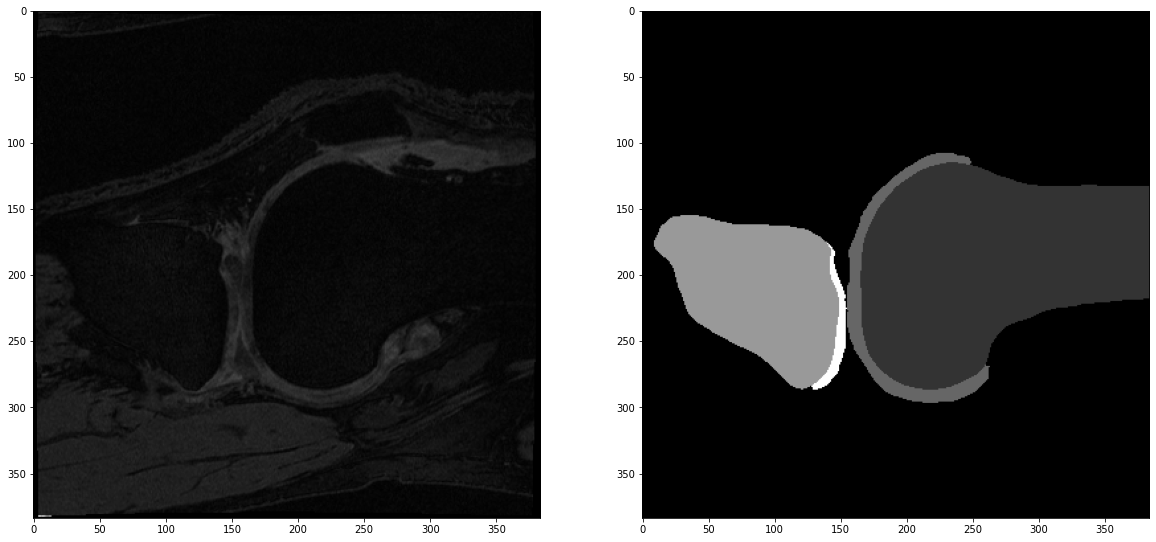

In [ ]:
img = nib.load('/content/train/train/9002817.nii.gz').get_fdata().astype('uint32')

mask = nib.load('/content/labels/labelmaps/train/9002817.nii.gz').get_fdata()

display = img[50,:,:]
mask_display = mask[50,:,:]

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(display, cmap = 'gray')
plt.subplot(122)
plt.imshow(mask_display, cmap='gray')


In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    lambda:patchify_data(train_path, train_masks_path),
    output_signature = ( tf.TensorSpec(shape=(16,10, 384, 384, 1), dtype=tf.float32),
                        tf.TensorSpec(shape=(16,10, 384, 384, n_classes), dtype=tf.float32)
                        )
)

train_dataset_10 = tf.data.Dataset.from_generator(
    lambda:patchify_data(train_path, train_masks_path, 0.5),
    output_signature = ( tf.TensorSpec(shape=(16,10, 384, 384, 1), dtype=tf.float32),
                        tf.TensorSpec(shape=(16,10, 384, 384, n_classes), dtype=tf.float32)
                        )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda:patchify_data(test_path, test_masks_path),
    output_signature = ( tf.TensorSpec(shape=(16,10, 384, 384, 1), dtype=tf.float32),
                        tf.TensorSpec(shape=(16,10, 384, 384, n_classes), dtype=tf.float32)
                        )
)

valid_dataset = tf.data.Dataset.from_generator(
    lambda:patchify_data(test_path, test_masks_path, 0.2),
    output_signature = ( tf.TensorSpec(shape=(16,10, 384, 384, 1), dtype=tf.float32),
                        tf.TensorSpec(shape=(16,10, 384, 384, n_classes), dtype=tf.float32)
                        )
)

adapt_dataset = tf.data.Dataset.from_generator(
    lambda: patchify_data_without_masks(train_path),
    output_signature = tf.TensorSpec(shape=(16,10, 384, 384, 1), dtype=tf.float32)
)

In [ ]:
first = valid_dataset.take(1)

for train, mask in first:
  print(train.shape)
  print(mask.shape)

(16, 10, 384, 384, 1)
(16, 10, 384, 384, 6)


## Training

In [ ]:
model = unet_3d(normalization_data=adapt_dataset)

(None, 10, 192, 192, 32)
(None, 10, 96, 96, 64)
(None, 10, 48, 48, 128)
(None, 5, 24, 24, 256)
(None, 5, 12, 12, 512)
(None, 5, 6, 6, 1024)
-------------
(None, 5, 3, 3, 1024)
-------------
(None, 5, 6, 6, 1024)
(None, 5, 12, 12, 512)
(None, 5, 24, 24, 256)
(None, 10, 48, 48, 128)
(None, 10, 96, 96, 64)
(None, 10, 192, 192, 32)
(None, 10, 384, 384, 6)


In [ ]:
model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

In [ ]:
history = model.fit(train_dataset,
                  epochs=100,
                  validation_data=valid_dataset,
                  callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
                   tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=4, verbose=1)] )

Epoch 1/100
406/406 [==============================] - 688s 2s/step - loss: 0.7102 - iou_score: 0.3070 - f1-score: 0.3851 - val_loss: 0.5622 - val_iou_score: 0.4591 - val_f1-score: 0.5383 - lr: 1.0000e-04
Epoch 2/100
406/406 [==============================] - 660s 2s/step - loss: 0.3337 - iou_score: 0.6013 - f1-score: 0.6802 - val_loss: 0.1489 - val_iou_score: 0.7791 - val_f1-score: 0.8600 - lr: 1.0000e-04
Epoch 3/100
406/406 [==============================] - 662s 2s/step - loss: 0.1432 - iou_score: 0.7867 - f1-score: 0.8655 - val_loss: 0.0987 - val_iou_score: 0.8442 - val_f1-score: 0.9088 - lr: 1.0000e-04
Epoch 4/100
406/406 [==============================] - 663s 2s/step - loss: 0.1055 - iou_score: 0.8340 - f1-score: 0.9018 - val_loss: 0.0880 - val_iou_score: 0.8585 - val_f1-score: 0.9184 - lr: 1.0000e-04
Epoch 5/100
406/406 [==============================] - 661s 2s/step - loss: 0.0952 - iou_score: 0.8481 - f1-score: 0.9117 - val_loss: 0.0861 - val_iou_score: 0.8612 - val_f1-score:

In [ ]:
model.evaluate(test_dataset)

101/101 [==============================] - 161s 2s/step - loss: 0.0837 - iou_score: 0.8643 - f1-score: 0.9219


[0.08365686982870102, 0.8643052577972412, 0.9218526482582092]

## Results analysis

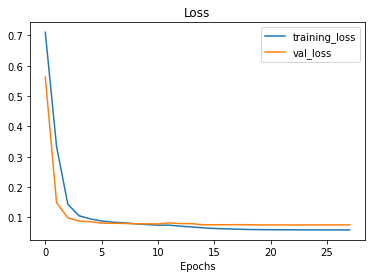

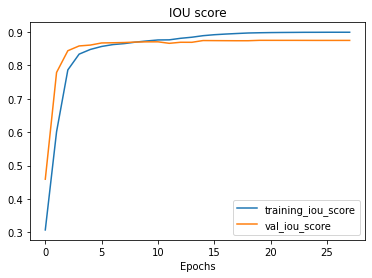

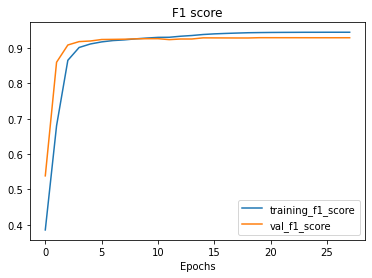

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

iou_score = history.history['iou_score']
val_iou_score = history.history['val_iou_score']

f1_score = history.history['f1-score']
val_f1_score = history.history['val_f1-score']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot IOU score
plt.figure()
plt.plot(epochs, iou_score, label='training_iou_score')
plt.plot(epochs, val_iou_score, label='val_iou_score')
plt.title('IOU score')
plt.xlabel('Epochs')
plt.legend();

# Plot IOU score
plt.figure()
plt.plot(epochs, f1_score, label='training_f1_score')
plt.plot(epochs, val_f1_score, label='val_f1_score')
plt.title('F1 score')
plt.xlabel('Epochs')
plt.legend();

In [ ]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 384, 38  0           []                               
                                4, 1)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 10, 192, 192  896         ['input_2[0][0]']                
                                , 32)                                                             
                                                                                                  
 conv3d_1 (Conv3D)              (None, 10, 192, 192  27680       ['conv3d[1][0]']                 
                                , 32)                                                         

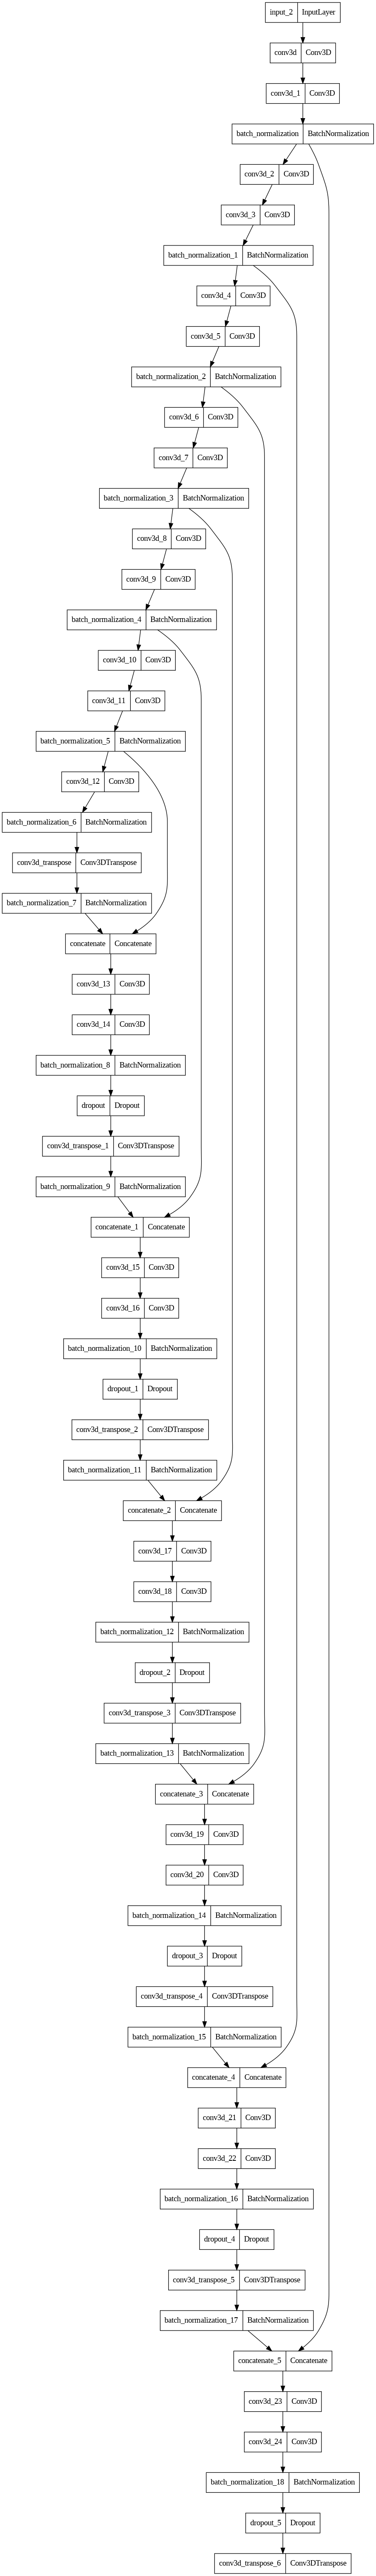

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model.save('/content/drive/MyDrive/knee_segmentation_final/tf_model')
model.save('/content/drive/MyDrive/knee_segmentation_final/model.h5')

In [ ]:
with keras.utils.custom_object_scope({'dice_loss_plus_1categorical_crossentropy': total_loss,
                                      'iou_score': sm.metrics.IOUScore(),
                                      'f1-score': sm.metrics.FScore()}):
    # Load the saved model
    my_model = tf.keras.models.load_model('/content/drive/MyDrive/knee_segmentation_final/model.h5')

In [ ]:
example = nib.load('/content/test/test/9156526.nii.gz').get_fdata().astype('float32')
example_patched =  patchify(example, (10, 384, 384), step=(10, 384, 384))
print(example_patched.shape)
example_patched = np.reshape(example_patched, (-1, example_patched.shape[3], example_patched.shape[4], example_patched.shape[5]))
example_patched_expand = np.expand_dims(example_patched, axis=-1)

truth = nib.load('/content/labels/labelmaps/test/9156526.nii.gz').get_fdata()
truth =  patchify(truth, (10, 384, 384), step=(10, 384, 384))
truth = np.reshape(truth, (-1, truth.shape[3], truth.shape[4], truth.shape[5]))

(16, 1, 1, 10, 384, 384)


In [ ]:
one_dim = np.expand_dims(example_patched_expand[9], axis=0)

pred = my_model.predict(one_dim)

1/1 [==============================] - 14s 14s/step


In [ ]:
pred_arg = np.argmax(pred,axis=4)[0]

In [ ]:
pred_arg.shape

(10, 384, 384)

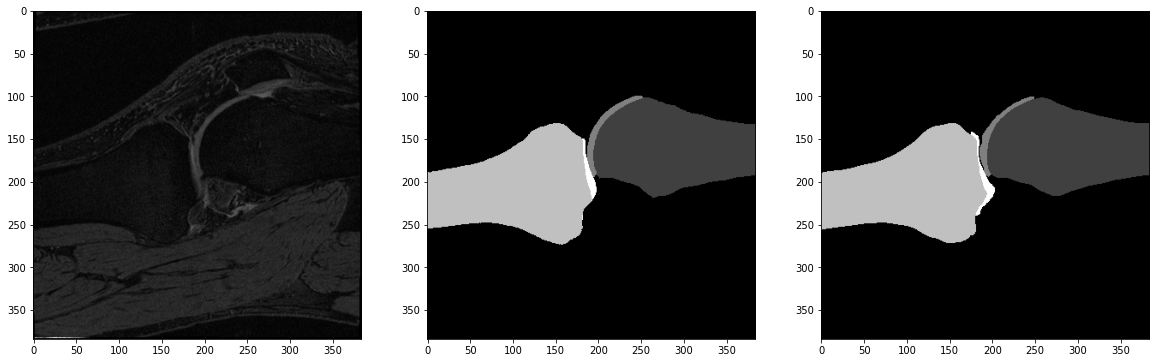

In [ ]:
display = example_patched[9,8,:,:]
mask = pred_arg[8]
display_max = truth[9,8,:,:]

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(display, cmap = 'gray')
plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.subplot(133)
plt.imshow(display_max, cmap='gray')

In [ ]:
pred_whole = my_model.predict(example_patched_expand)

1/1 [==============================] - 198s 198s/step


In [ ]:
pred_args = np.argmax(pred_whole,axis=4)
print(pred_args.shape)
pred_reshaped = pred_args.reshape(16, 1, 1, 10, 384, 384)
unpatched = unpatchify(pred_reshaped, (160, 384, 384))

(16, 10, 384, 384)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


truth_flatten = truth.flatten()
preds_flatten = pred_args.flatten()
values = confusion_matrix(truth_flatten,preds_flatten)


In [ ]:
values

array([[20270751,    10058,    10489,    17607,     1908,     2183],
       [   17069,  1653473,     6018,        0,        0,        0],
       [   11829,     1630,   113386,        0,      878,      670],
       [   18382,        0,        0,  1421580,      997,      452],
       [    2744,        0,      118,      334,    12023,        0],
       [    1211,        0,      120,      367,        0,    16683]])

In [ ]:
class1_IoU = values[1,1]/(values[1,1] + values[1,2] + values[1,3] + values[1,4] + values[1,5] + values[1,0] + values[2,1]+ values[3,1]+ values[4,1] + values[5,1] + values[0,1])
class1_IoU = values[1,1]/(values[1,1] + values[1,2] + values[1,3] + values[1,4] + values[1,5] + values[1,0] + values[2,1]+ values[3,1]+ values[4,1] + values[5,1] + values[0,1])
class2_IoU = values[2,2]/(values[2,2] + values[2,1] + values[2,3] + values[2,4] + values[2,5] + values[2,0] + values[1,2]+ values[3,2]+ values[4,2] + values[5,2] + values[0,2])
class3_IoU = values[3,3]/(values[3,3] + values[3,1] + values[3,2] + values[3,4] + values[3,5] + values[3,0] + values[1,3]+ values[2,3]+ values[4,3] + values[5,3] + values[0,3])
class4_IoU = values[4,4]/(values[4,4] + values[4,1] + values[4,3] + values[4,2] + values[4,5] + values[4,0] + values[1,4]+ values[3,4]+ values[2,4] + values[5,4] + values[0,4])
class5_IoU = values[5,5]/(values[5,5] + values[5,1] + values[5,3] + values[5,4] + values[5,2] + values[5,0] + values[1,5]+ values[3,5]+ values[4,5] + values[2,5] + values[0,5])
class6_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,3] + values[0,4] + values[0,5] + values[0,2] + values[1,0]+ values[3,0]+ values[4,0] + values[5,0] + values[2,0])

class1_IoU, class2_IoU, class3_IoU, class4_IoU, class5_IoU, class6_IoU

(0.9794017229696111,
 0.7812288993923024,
 0.9738723685860087,
 0.6327228712767077,
 0.7692981647145624,
 0.9954095983295417)

In [ ]:
(class1_IoU + class2_IoU+class3_IoU+ class4_IoU+ class5_IoU+ class6_IoU)/6

0.8553222708781223

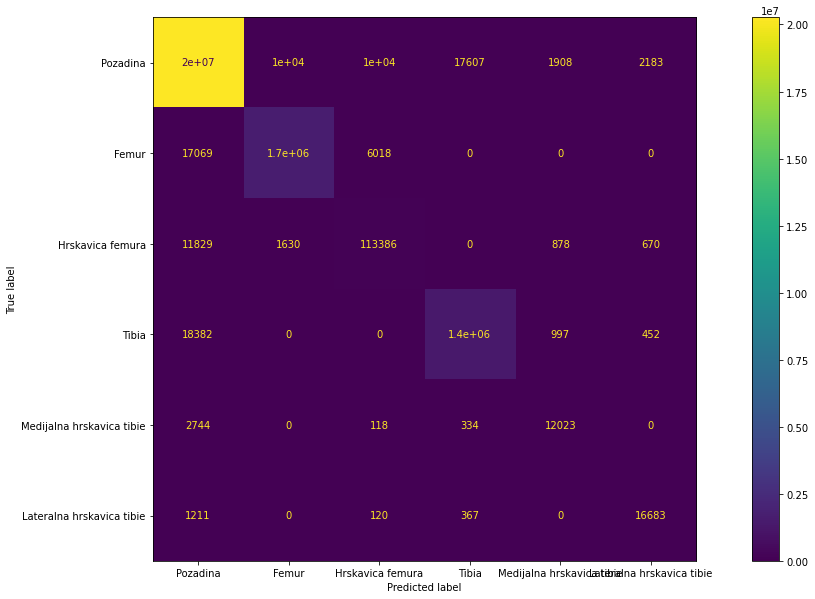

In [ ]:
disp = ConfusionMatrixDisplay(values, display_labels = ["Pozadina", "Femur", "Hrskavica femura", "Tibia", "Medijalna hrskavica tibie", "Lateralna hrskavica tibie"])
fig, ax = plt.subplots(figsize=(20,10))
disp.plot(ax=ax)

In [ ]:
unpatched.shape

(160, 384, 384)

## Saving image in nifti to preview prediction

In [ ]:
# Take headers from random mask
example_mask = nib.load('/content/labels/labelmaps/test/9156526.nii.gz')

pred_img = nib.Nifti1Image(unpatched, example_mask.affine, example_mask.header)
nib.save(pred_img, 'pred_img_9156526.nii')